# Address parsing and correction

In this notebook, I will describe the use of CRF models in [libpostal address parser](https://github.com/openvenues/libpostal) and how they differ from newer language processing methods, namely RNN and LSTM. In the CRF model each sequence is remembered and a tag is given to each word, depending on the neighbouring words.  The neighbouring words are kept in a structure which can be represented as a vector:

![one-hot encodings](assets/ccrfDiagram.png)

The main limitation here is in the vector that keeps the neighbourhood information. The model will learn to associate words to tags over time, however only in that fixed relative position with each other. If there are additional words to change the structure of an input, as it was during training, the output will not be reproducible. As an example lets take a model that has been trained with input of this format:

64 Great Eastern Street London EC2A 3QR

If we now insert new information about the whereabouts of our address into the input:

64 Great Eastern Street Ingrove Court London EC2A 3QR

 Assume such an address exists but Ingrove Court does not need to be included for the postman to identify this address. The model cannot tell you whether Ingrove is part of the street. It has never seen data before to show it that explicitly Ingrove Court is an optional part of the address. This is why it is a good idea to find common points in the data where there can be additional words with different contextual meaning eg. street names, suburbs, cities etc etc... Commonly in NLP only the most common words are used to represent meaning of a sentence or tagging of word meanings.

An LSTM in contrast, is capable of remembering word occurances that are several words away and will be able to resolve such problems. This is by virtue of a non-linearity in nearby word association that is not simply composed of a vector, rather it is a state represented by neural networks.

In order to demonstrate this associations I will create word embeddings for a small set of addresses. I'll convert addresses to vectors through TensorFlow and understand the common meaning behind them.


Embeddings are just a single layer neural network. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. The information that goes into this matrix is the occurance of the words within a small range away of our chosen word. The sequences in the input however will help us understand what each word means and what role it plays in the sentence.

![one-hot encodings](assets/word2vec_architectures.png)




We use the [openaddress US North East dataset](https://s3.amazonaws.com/data.openaddresses.io/openaddr-collected-us_northeast.zip), and train the model using tensorflow. Refer to [addr2vec.py](https://github.com/bmbigbang/deep-learning/blob/master/embeddings/addr2vec.py) for further details. Below is a snippet of word similarities during training:


Nearest to Apple: DONELLAN, WINDAGO, GUES, -3140, ORONOQUE, MUNSTER, DRUMS, Dozzy,

Nearest to West: Strawberry, Second, Hemlock, Port, Woodside, End, Worcester, Broadway,

Nearest to Curtis: Silver, Charles, Depot, Waldo, Lawrence, Poland, Nichols, Berry,

Nearest to St: ME, Rd, N, Bog, Ln, S, Pl, E,

Nearest to Dr: Ln, Cir, Rd, River, Rock, Nelson, Leighton, St,

Nearest to Way: Blueberry, Winding, Mountain, Sea, Woods, Point, Willow, Landing,

Nearest to Sagadahoc: Bradley, School, TP, Farm, Ledge, Union, Duck, Acres,

Nearest to Beechnut: FRUM, Bellen, 13/14, #2386, JENNERSVILLE, Caledomia, 24-26, OGONTZ,

Nearest to Blanket: 4052A, Haggett, DULCY, Hgts, ORKNEY, JASINSKI, APPLEWINE, CV,

Nearest to Porter: Snow, Bell, Locust, Morris, Logan, Harold, Howe, Station,

Nearest to H: J, C, A, D, F, I, G, LANE-PERRY,

Nearest to Milliken: Sturlane, ASHWICKEN, ZERNICH, DIMARTINO, HATCHFIELD, #2029, Mosse, Mountaineer,

Nearest to Lucette: Christiansted, Sisters, #1461, 3104, #076, ICY, BRISTORIA, Newtowne,

Nearest to Donald: HENGER, Lishness, Mediacom, AUSTON, LEVEN, Rondel, VINNY, Harwin,

Nearest to Matthew: JADOS, MARRICK, CUTTING'S, 3079, Pellman, Monarda, Ormand, Kukui,

Nearest to Hawes: BORROR, DELA, Kostek, Bortons, GOWARD, Cosners, Belle-Oaks, DYE,

Epoch 10/10 Iteration: 369100 Avg. Training loss: 0.4056 0.0284 sec/batch

Epoch 10/10 Iteration: 369200 Avg. Training loss: 0.6151 0.0264 sec/batch


Further visualising the network structure and running an example sentence.

In [20]:
import pickle

embed_mat = pickle.load(open('/home/ubuntu/embed_mat.p', 'rb'))
id_to_vocab = pickle.load(open('/home/ubuntu/id_to_vocab.p', 'rb'))

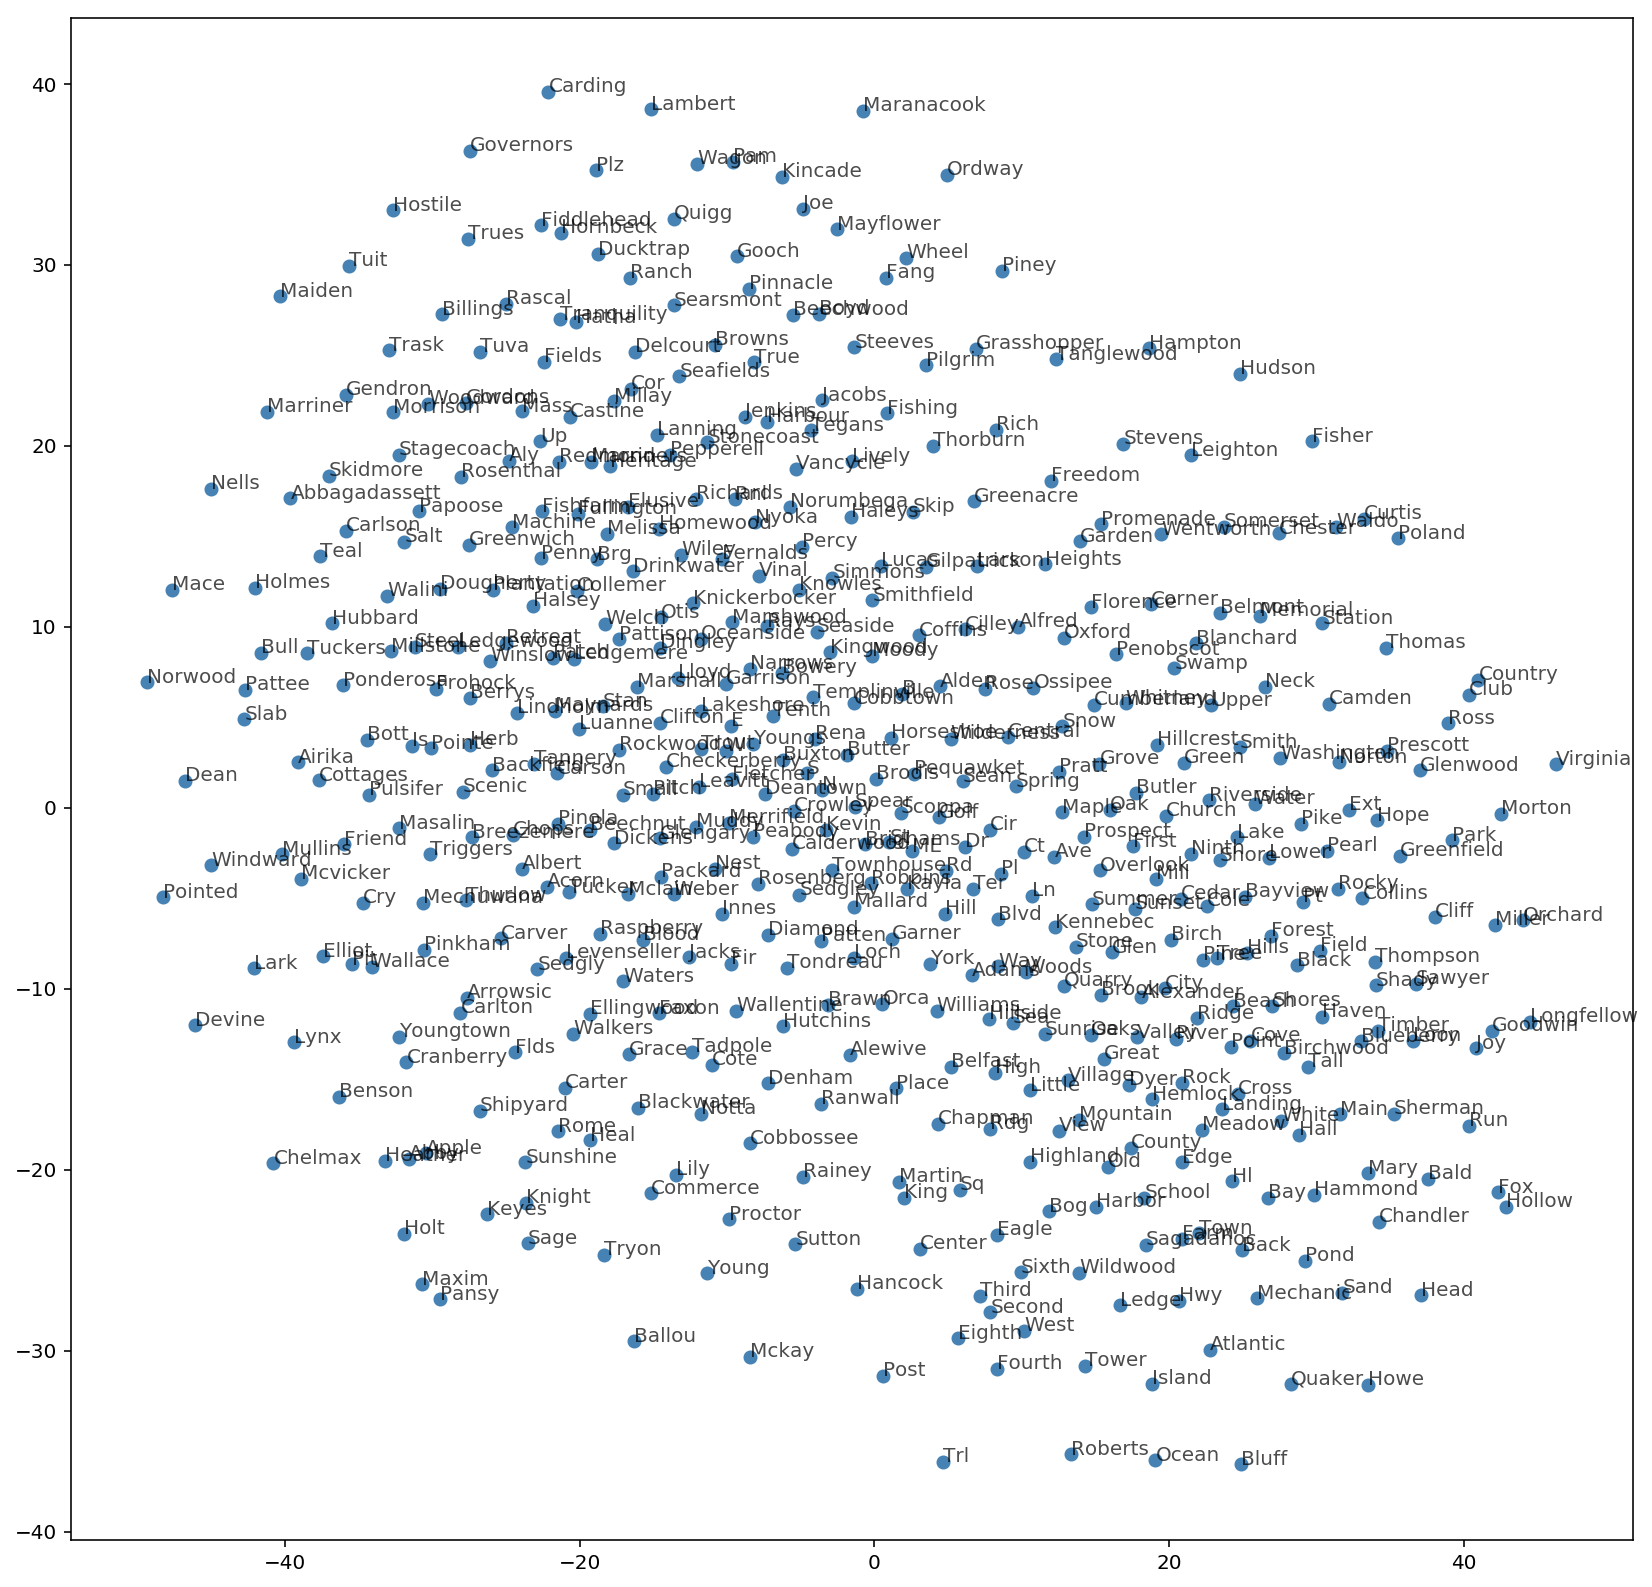

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])


fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(id_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

So we can see that the embeddings have reveal the word similarities in the addresses. The CRF works in a similar way using a simple Perceptron (single layer neural network) to find vector representation of words, and then attempts to label them by their similarity.